In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import shap
import json
import os

In [2]:
# Setting the same seed as in train.py is very important 
# as to assess the model on the same validation set as the one constructed in train.py
seed = 0
TARGET_COLUMN = "SeriousDlqin2yrs"

In [3]:
notebook_path = os.path.abspath("assess.ipynb")
project_dir = Path(notebook_path).resolve().parents[1]
model_dir = "{}/{}".format(project_dir, "models")
params_dir = "{}/{}".format(project_dir, "params")
raw_dir = "{}/{}".format(project_dir, "data/raw")

### Load dataset

In [4]:
dataset_filepath = "{}/{}".format(raw_dir, "cs-training.csv")

# Shuffle with the same seed as in train.py
df_dataset = pd.read_csv(dataset_filepath, index_col=0)
df_dataset.fillna(value=-1, inplace=True)
df_dataset = df_dataset.sample(frac=1, random_state=seed)

columns = df_dataset.columns.tolist()
feature_columns = sorted([column for column in columns if column != TARGET_COLUMN])

X = df_dataset[feature_columns].values
Y = df_dataset[TARGET_COLUMN].values

### Load model

In [5]:
model_json = "{}/{}".format(params_dir, "def_xgb_model.json")
with open(model_json, "r") as f:
        model_dict = json.loads(f.read())
model_name = model_dict["name"]
model_filepath = "{}/{}.pkl".format(model_dir, model_name)
with open(model_filepath, "rb") as f:
    model = pickle.load(f)

### Get validation set

In [6]:
# Get exactly same validation set as in train.py
split_ratio = 0.9
validation_idxs = [int((split_ratio) * df_dataset.shape[0]), df_dataset.shape[0]]
X_validation = X[validation_idxs[0]:validation_idxs[1]]
y_validation = Y[validation_idxs[0]:validation_idxs[1]]

### Apply model on validation set

In [7]:
y_true = y_validation.copy().reshape(-1, 1)
# Proba output for each class
y_score = model.predict_proba(X_validation)[:, 1]
# Class output
y_pred = model.predict(X_validation)

### Look at Score distribution per class

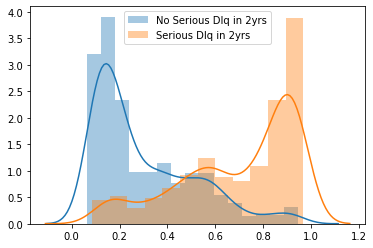

In [8]:
sns.distplot(np.random.choice(y_score[np.where(y_true == 0)[0]], size=1000), label="No Serious Dlq in 2yrs")
sns.distplot(np.random.choice(y_score[np.where(y_true == 1)[0]], size=1000), label="Serious Dlq in 2yrs")
plt.legend()

### Confusion matrix

In [9]:
cm = confusion_matrix(y_true=y_true,
                      y_pred=y_pred)

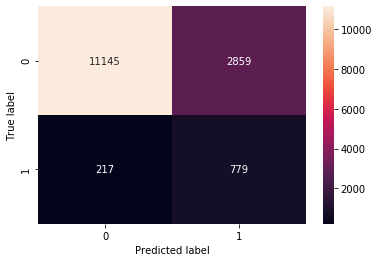

In [10]:
fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt="d")
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

### ROC curve

In [11]:
fpr, tpr, roc_thresholds = roc_curve(y_true=y_true,
                                     y_score=y_score)

In [12]:
roc_thresholds

array([1.9704365 , 0.97043645, 0.9703151 , ..., 0.06152034, 0.06102186,
       0.05948503], dtype=float32)

Text(0, 0.5, 'TPR')

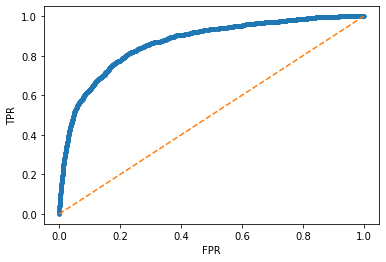

In [13]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

In [14]:
AUC_score = roc_auc_score(y_true=y_true,
                          y_score=y_score)

In [15]:
# Should match the Val AUC obtained after running "make train_def"
AUC_score

0.8673918395662055

### Precision - Recall curve 

In [16]:
precision, recall, pr_thresholds = precision_recall_curve(y_true=y_true,
                                                          probas_pred=y_score,
                                                          pos_label=1)

Text(0, 0.5, 'Precision')

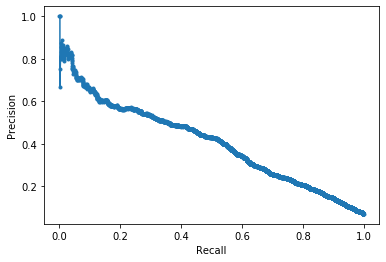

In [17]:
fig, ax = plt.subplots()
plt.plot(recall, precision, marker='.')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

In [18]:
auc(recall, precision)

0.407166332390943

### F1 curve

In [19]:
F1 = 2 * precision * recall / (precision + recall)

Text(0, 0.5, 'F1')

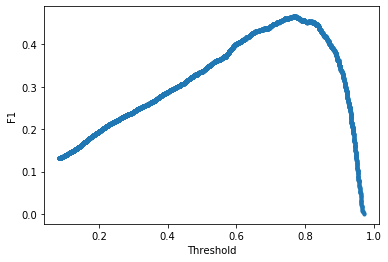

In [20]:
fig, ax = plt.subplots()
plt.plot(pr_thresholds, F1[1:], marker='.')
ax.set_xlabel("Threshold")
ax.set_ylabel("F1")

### Feature importance

In [21]:
feature_columns

['DebtRatio',
 'MonthlyIncome',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [22]:
# ‘weight’: the number of times a feature is used to split the data across all trees.
model.get_booster().feature_names = feature_columns
df_weight = pd.DataFrame([model.get_booster().get_score(importance_type='weight')])
df_weight = df_weight.transpose()
df_weight.reset_index(inplace=True)
df_weight.sort_values(by=0, inplace=True)

In [23]:
df_weight

,index,0
2,NumberOfDependents,43
7,NumberRealEstateLoansOrLines,101
4,NumberOfTime30-59DaysPastDueNotWorse,118
5,NumberOfTime60-89DaysPastDueNotWorse,134
9,age,149
1,MonthlyIncome,150
3,NumberOfOpenCreditLinesAndLoans,152
6,NumberOfTimes90DaysLate,195
0,DebtRatio,223
8,RevolvingUtilizationOfUnsecuredLines,232


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

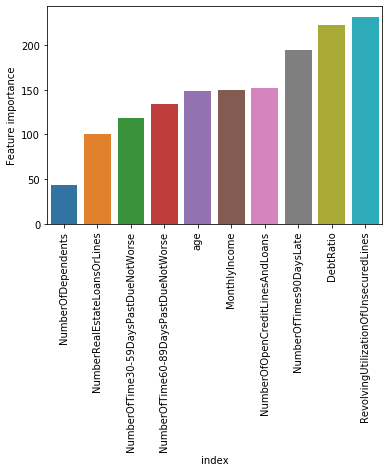

In [24]:
ax = sns.barplot(x="index", y=0, data=df_weight)
degrees = 90
ax.set_ylabel("Feature importance")
plt.xticks(rotation=degrees)

### Shapley values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


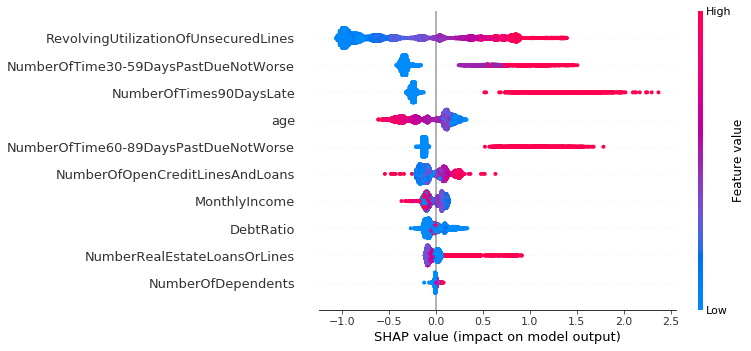

In [25]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_validation)
shap.summary_plot(shap_values, X_validation, feature_names=feature_columns)